# 1.13c: Lattice Topology Analysis

**Goal:** Analyze the graph structure of orthogonal lattice neighbors.

## Method

Build an undirected graph where:
- **Nodes**: Tokens (128)
- **Edges**: Orthogonal neighbor relationships (differ by ±1 mantissa in exactly 1 dimension)

Analyze:
1. **Connected components**: How many disconnected subgraphs?
2. **Component sizes**: Distribution of component membership
3. **Graph properties**: Diameter, density, clustering
4. **Degree distribution**: Network view of connectivity

## Key Questions

- Is this one giant connected component or many small clusters?
- If connected, what's the maximum distance between any two tokens?
- Are there hub tokens that connect different regions?

## Input

Load results from 1.13b (orthogonal neighbor pairs).

## Parameters

In [15]:
# Input from 1.13b
STRUCTURE_FILE = "../tensors/Lil_Gatsby/1.13b_1.12a_training_data_step-1_structure.safetensors"

# Need to reload W to reconstruct edge list
TENSOR_FILE = "../tensors/Lil_Gatsby/1.12a_training_data.safetensors"
TENSOR_KEY = "W"
TENSOR_INDEX = 0

## Imports

In [16]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx

## Load Data

In [17]:
# Load structure results from 1.13b
structure_data = load_file(STRUCTURE_FILE)
orthogonal_tokens = structure_data['orthogonal_tokens'].tolist()

print(f"✓ Loaded structure from {Path(STRUCTURE_FILE).name}")
print(f"  Orthogonal tokens: {len(orthogonal_tokens)}")

# Load W matrix to reconstruct edges
tensor_data = load_file(TENSOR_FILE)
W = tensor_data[TENSOR_KEY]
if TENSOR_INDEX is not None:
    W = W[TENSOR_INDEX]

n_vectors, n_dims = W.shape
print(f"\n✓ Loaded W matrix")
print(f"  Shape: {W.shape}")
print(f"  Dtype: {W.dtype}")

✓ Loaded structure from 1.13b_1.12a_training_data_step-1_structure.safetensors
  Orthogonal tokens: 128

✓ Loaded W matrix
  Shape: torch.Size([128, 64])
  Dtype: torch.bfloat16


## Helper Functions (from 1.13b)

In [18]:
def decode_bfloat16_components(values_bf16):
    """
    Decode bfloat16 values into sign, exponent, mantissa components.
    """
    values_uint16 = values_bf16.view(torch.int16).to(torch.int64) & 0xFFFF
    
    signs = (values_uint16 >> 15) & 0x1
    exponents = (values_uint16 >> 7) & 0xFF
    mantissas = values_uint16 & 0x7F
    
    return {
        'uint16': values_uint16,
        'signs': signs,
        'exponents': exponents,
        'mantissas': mantissas
    }

def find_dimension_differences(vec_a, vec_b):
    """
    Find dimensions where two vectors differ by exactly ±1 mantissa (same sign, same exp).
    """
    decoded_a = decode_bfloat16_components(vec_a)
    decoded_b = decode_bfloat16_components(vec_b)
    
    same_sign = decoded_a['signs'] == decoded_b['signs']
    same_exp = decoded_a['exponents'] == decoded_b['exponents']
    mant_diff = (decoded_a['mantissas'] - decoded_b['mantissas']).abs()
    mant_diff_one = mant_diff == 1
    
    is_neighbor = same_sign & same_exp & mant_diff_one
    neighbor_dims = is_neighbor.nonzero(as_tuple=True)[0].tolist()
    
    return neighbor_dims

print("✓ Helper functions defined")

✓ Helper functions defined


## Build Orthogonal Neighbor Graph

In [19]:
print("\n" + "=" * 80)
print("BUILDING GRAPH")
print("=" * 80)
print()

# Create empty graph
G = nx.Graph()

# Add all tokens as nodes
G.add_nodes_from(range(n_vectors))

# Find all orthogonal neighbor pairs and add as edges
print("Finding orthogonal neighbor pairs...")
edges = []

for i in range(n_vectors):
    if i % 20 == 0:
        print(f"  Progress: {i}/{n_vectors}", end='\r')
    for j in range(i + 1, n_vectors):
        diff_dims = find_dimension_differences(W[i], W[j])
        
        # Orthogonal = exactly 1 dimension differs
        if len(diff_dims) == 1:
            edges.append((i, j))

G.add_edges_from(edges)

print(f"\n\n✓ Graph constructed")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Density: {nx.density(G):.4f}")
print()


BUILDING GRAPH

Finding orthogonal neighbor pairs...
  Progress: 120/128

✓ Graph constructed
  Nodes: 128
  Edges: 804
  Density: 0.0989



## Connected Components Analysis

In [20]:
print("\n" + "=" * 80)
print("CONNECTED COMPONENTS ANALYSIS")
print("=" * 80)
print()

# Find connected components
components = list(nx.connected_components(G))
n_components = len(components)

print(f"Number of connected components: {n_components}\n")

# Sort components by size
components_sorted = sorted(components, key=len, reverse=True)

# Show component sizes
print(f"Component sizes:")
for i, component in enumerate(components_sorted):
    size = len(component)
    pct = 100 * size / n_vectors
    print(f"  Component {i+1}: {size:4d} tokens ({pct:5.1f}%)")
    
    if i < 5:  # Show members of first 5 components
        members = sorted(component)
        if len(members) <= 20:
            print(f"    Members: {members}")
        else:
            print(f"    Members: {members[:10]} ... {members[-10:]}")
    
    if i >= 9:  # Stop after 10 components
        if len(components_sorted) > 10:
            print(f"  ... and {len(components_sorted) - 10} more components")
        break

print()


CONNECTED COMPONENTS ANALYSIS

Number of connected components: 1

Component sizes:
  Component 1:  128 tokens (100.0%)
    Members: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ... [118, 119, 120, 121, 122, 123, 124, 125, 126, 127]



## Graph Properties (Largest Component)

In [21]:
print("\n" + "=" * 80)
print("GRAPH PROPERTIES (LARGEST COMPONENT)")
print("=" * 80)
print()

# Get largest component
largest_component = max(components, key=len)
G_largest = G.subgraph(largest_component).copy()

print(f"Largest component size: {len(largest_component)} tokens\n")

# Compute graph properties
print(f"Graph properties:")
print(f"  Nodes: {G_largest.number_of_nodes()}")
print(f"  Edges: {G_largest.number_of_edges()}")
print(f"  Density: {nx.density(G_largest):.4f}")

# Diameter (longest shortest path)
if nx.is_connected(G_largest):
    diameter = nx.diameter(G_largest)
    print(f"  Diameter: {diameter} (max distance between any two tokens)")
    
    # Average shortest path length
    avg_path_length = nx.average_shortest_path_length(G_largest)
    print(f"  Average path length: {avg_path_length:.2f}")
else:
    print(f"  Diameter: N/A (not connected)")

# Clustering coefficient
clustering = nx.average_clustering(G_largest)
print(f"  Average clustering coefficient: {clustering:.4f}")

# Degree statistics
degrees = [G_largest.degree(n) for n in G_largest.nodes()]
print(f"\nDegree statistics:")
print(f"  Min: {min(degrees)}")
print(f"  Max: {max(degrees)}")
print(f"  Mean: {np.mean(degrees):.2f}")
print(f"  Median: {np.median(degrees):.2f}")

# Find hub nodes (highest degree)
degree_dict = dict(G_largest.degree())
hubs = sorted(degree_dict.items(), key=lambda x: -x[1])[:10]
print(f"\nTop 10 hub tokens (by degree):")
for token, degree in hubs:
    print(f"  Token {token:4d}: {degree:3d} neighbors")

print()


GRAPH PROPERTIES (LARGEST COMPONENT)

Largest component size: 128 tokens

Graph properties:
  Nodes: 128
  Edges: 804
  Density: 0.0989
  Diameter: 4 (max distance between any two tokens)
  Average path length: 2.17
  Average clustering coefficient: 0.0972

Degree statistics:
  Min: 3
  Max: 23
  Mean: 12.56
  Median: 12.00

Top 10 hub tokens (by degree):
  Token   78:  23 neighbors
  Token   53:  21 neighbors
  Token   72:  21 neighbors
  Token   15:  20 neighbors
  Token   30:  20 neighbors
  Token   55:  20 neighbors
  Token  116:  20 neighbors
  Token  119:  20 neighbors
  Token  120:  19 neighbors
  Token    7:  18 neighbors



## Distance Distribution

In [22]:
if nx.is_connected(G_largest) and len(G_largest) <= 200:
    print("\n" + "=" * 80)
    print("DISTANCE DISTRIBUTION")
    print("=" * 80)
    print()
    
    # Compute all pairwise shortest paths
    print("Computing all pairwise shortest paths...")
    all_paths = dict(nx.all_pairs_shortest_path_length(G_largest))
    
    # Extract all distances
    distances = []
    for source in all_paths:
        for target, distance in all_paths[source].items():
            if source < target:  # Only count each pair once
                distances.append(distance)
    
    # Show distribution
    distance_counts = Counter(distances)
    print(f"\nDistance distribution:")
    for dist in sorted(distance_counts.keys()):
        count = distance_counts[dist]
        pct = 100 * count / len(distances)
        print(f"  Distance {dist}: {count:6,} pairs ({pct:5.1f}%)")
    
    print(f"\nTotal pairs: {len(distances):,}")
    print()
else:
    print("\n(Skipping distance distribution: component too large or not connected)\n")


DISTANCE DISTRIBUTION

Computing all pairwise shortest paths...

Distance distribution:
  Distance 1:    804 pairs (  9.9%)
  Distance 2:  5,158 pairs ( 63.5%)
  Distance 3:  2,160 pairs ( 26.6%)
  Distance 4:      6 pairs (  0.1%)

Total pairs: 8,128



## Visualizations

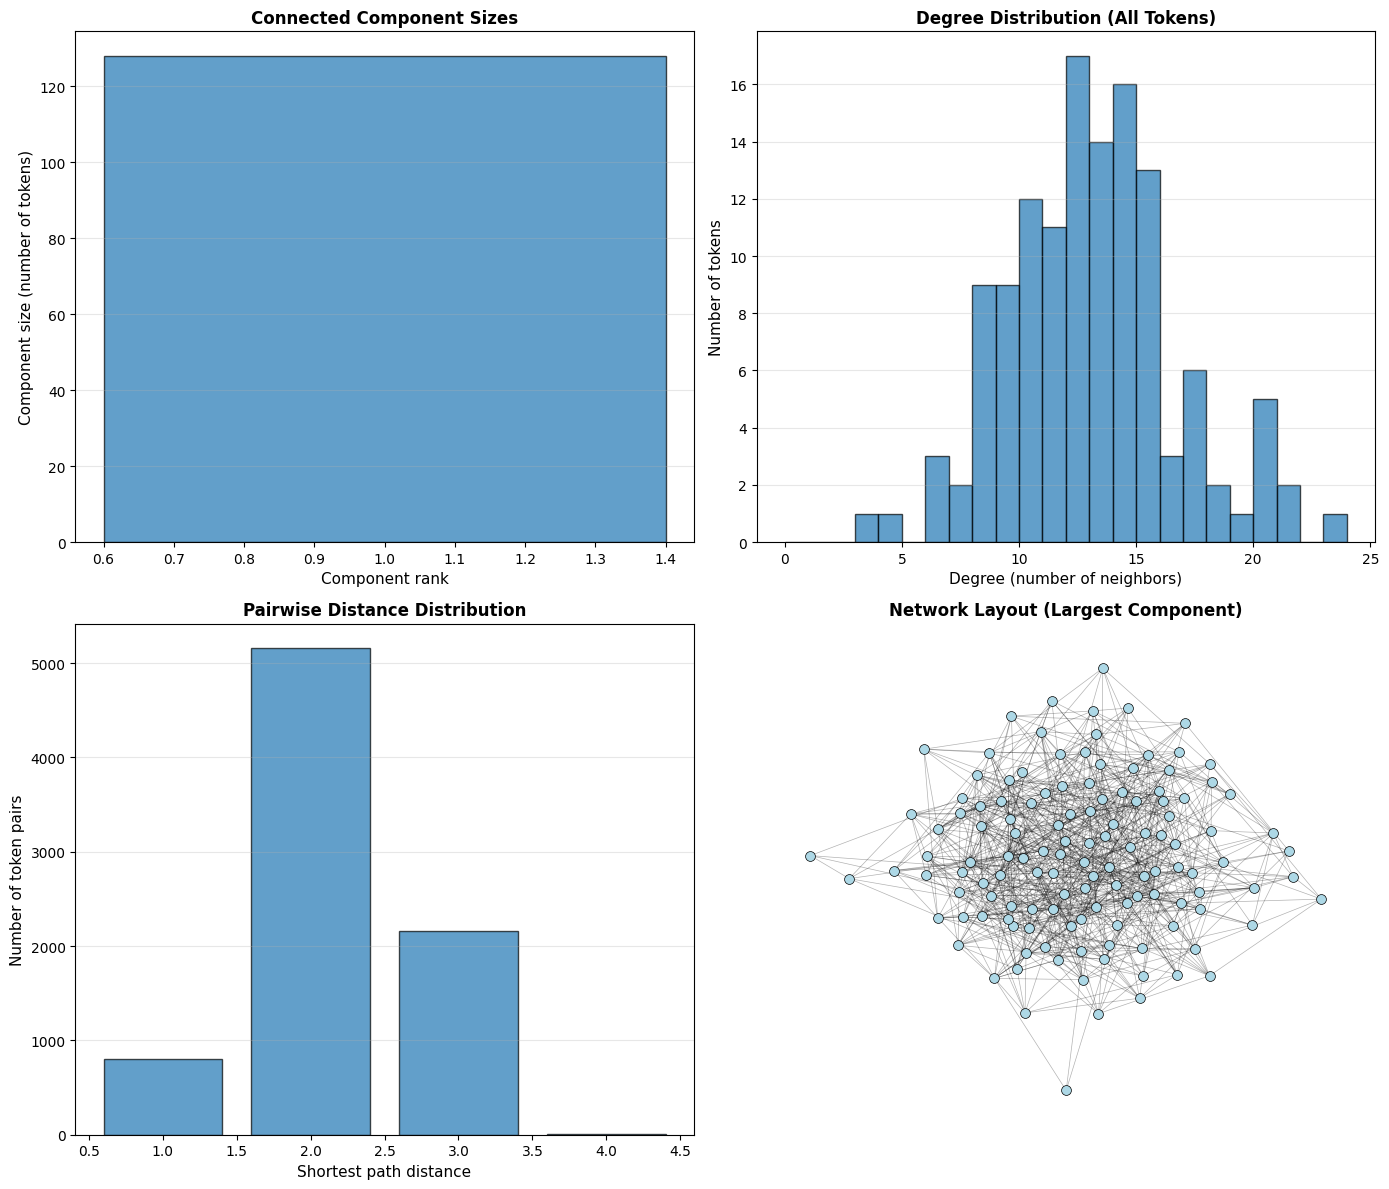

✓ Visualizations complete


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12), dpi=100)

# Plot 1: Component sizes
ax = axes[0, 0]
component_sizes = [len(c) for c in components_sorted]
ax.bar(range(1, len(component_sizes)+1), component_sizes, edgecolor='black', alpha=0.7)
ax.set_xlabel('Component rank', fontsize=11)
ax.set_ylabel('Component size (number of tokens)', fontsize=11)
ax.set_title('Connected Component Sizes', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 2: Degree distribution
ax = axes[0, 1]
all_degrees = [G.degree(n) for n in G.nodes()]
ax.hist(all_degrees, bins=range(0, max(all_degrees)+2), edgecolor='black', alpha=0.7)
ax.set_xlabel('Degree (number of neighbors)', fontsize=11)
ax.set_ylabel('Number of tokens', fontsize=11)
ax.set_title('Degree Distribution (All Tokens)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 3: Distance distribution (if available)
ax = axes[1, 0]
if nx.is_connected(G_largest) and len(G_largest) <= 200:
    ax.bar(sorted(distance_counts.keys()), [distance_counts[k] for k in sorted(distance_counts.keys())], 
           edgecolor='black', alpha=0.7)
    ax.set_xlabel('Shortest path distance', fontsize=11)
    ax.set_ylabel('Number of token pairs', fontsize=11)
    ax.set_title('Pairwise Distance Distribution', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Distance distribution\nskipped (too large)', 
            ha='center', va='center', fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])

# Plot 4: Network visualization (force-directed layout)
ax = axes[1, 1]
if len(G_largest) <= 200:
    # Small enough to visualize clearly
    pos = nx.spring_layout(G_largest, k=0.5, iterations=50, seed=42)
    nx.draw_networkx_nodes(G_largest, pos, node_size=50, node_color='lightblue', 
                           edgecolors='black', linewidths=0.5, ax=ax)
    nx.draw_networkx_edges(G_largest, pos, alpha=0.3, width=0.5, ax=ax)
    ax.set_title('Network Layout (Largest Component)', fontsize=12, fontweight='bold')
    ax.axis('off')
else:
    # Too large, just show a message
    ax.text(0.5, 0.5, f'Network visualization\nskipped\n({len(G_largest)} nodes too large)', 
            ha='center', va='center', fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Summary

In [24]:
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print()

print(f"Graph structure:")
print(f"  Total tokens: {n_vectors}")
print(f"  Connected components: {n_components}")
print(f"  Largest component: {len(largest_component)} tokens ({100*len(largest_component)/n_vectors:.1f}%)")
print()

if n_components == 1:
    print("✓ FULLY CONNECTED GRAPH")
    print(f"  All {n_vectors} tokens form a single connected lattice structure.")
    print(f"  Maximum distance between any two tokens: {diameter} hops")
    print(f"  Average distance: {avg_path_length:.2f} hops")
    print()
    print("Interpretation:")
    print(f"  • Every token can reach every other token via orthogonal lattice steps")
    print(f"  • The embedding space forms a single connected lattice manifold")
    print(f"  • Typical distance between tokens: ~{avg_path_length:.0f} single-mantissa jumps")
elif len(largest_component) > n_vectors * 0.9:
    print("⚠️  MOSTLY CONNECTED")
    print(f"  One giant component ({len(largest_component)} tokens) plus {n_components-1} small clusters.")
    print()
    print("Interpretation:")
    print(f"  • Most tokens form a connected lattice")
    print(f"  • A few outliers are isolated or form small groups")
else:
    print("⚠️  FRAGMENTED LATTICE")
    print(f"  {n_components} disconnected components")
    print(f"  Largest: {len(largest_component)} tokens ({100*len(largest_component)/n_vectors:.1f}%)")
    print()
    print("Interpretation:")
    print(f"  • The lattice structure is fragmented into {n_components} disconnected regions")
    print(f"  • Tokens within a component can reach each other, but not across components")

print()
print("Next steps:")
print("  → Compare to initialization (is it connected from the start?)")
print("  → Track connectivity over training trajectory")
print("  → Analyze which dimensions create the most connections")

print("\n" + "=" * 80)


SUMMARY

Graph structure:
  Total tokens: 128
  Connected components: 1
  Largest component: 128 tokens (100.0%)

✓ FULLY CONNECTED GRAPH
  All 128 tokens form a single connected lattice structure.
  Maximum distance between any two tokens: 4 hops
  Average distance: 2.17 hops

Interpretation:
  • Every token can reach every other token via orthogonal lattice steps
  • The embedding space forms a single connected lattice manifold
  • Typical distance between tokens: ~2 single-mantissa jumps

Next steps:
  → Compare to initialization (is it connected from the start?)
  → Track connectivity over training trajectory
  → Analyze which dimensions create the most connections



## Save Results

In [25]:
# Save component membership
output_path = "../tensors/Lil_Gatsby/1.13c_topology.safetensors"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)

# Create component labels tensor
component_labels = torch.zeros(n_vectors, dtype=torch.int64)
for i, component in enumerate(components_sorted):
    for token in component:
        component_labels[token] = i

# Create largest component mask
largest_component_mask = torch.zeros(n_vectors, dtype=torch.bool)
largest_component_mask[list(largest_component)] = True

save_file(
    {
        'component_labels': component_labels,
        'largest_component_mask': largest_component_mask,
        'n_components': torch.tensor(n_components, dtype=torch.int64),
    },
    output_path,
    metadata={
        'n_vectors': str(n_vectors),
        'n_components': str(n_components),
        'largest_component_size': str(len(largest_component)),
        'diameter': str(diameter) if nx.is_connected(G_largest) else 'N/A',
        'avg_path_length': f"{avg_path_length:.2f}" if nx.is_connected(G_largest) else 'N/A',
    }
)

print(f"\n✓ Saved topology results to {output_path}")


✓ Saved topology results to ../tensors/Lil_Gatsby/1.13c_topology.safetensors
